# Dataset: Baseball Players

In this lab, we will use predictive modeling to design a model that predicts a baseball player's salary in a given year.

This dataset was originally taken from the StatLib library which is maintained at Carnegie Mellon University. This is part of the data that was used in the 1988 ASA Graphics Section Poster Session. The salary data were originally from Sports Illustrated, April 20, 1987. The 1986 and career statistics were obtained from The 1987 Baseball Encyclopedia Update published by Collier Books, Macmillan Publishing Company, New York.

**Format:** A data frame with 322 observations of major league players on the following 20 variables.

`AtBat` Number of times at bat in 1986 

`Hits` Number of hits in 1986 

`HmRun` Number of home runs in 1986

`Runs` Number of runs in 1986 

`RBI` Number of runs batted in in 1986 

`Walks` Number of walks in 1986 

`Years` Number of years in the major leagues 

`CAtBat` Number of times at bat during his career 

`CHits` Number of hits during his career 

`CHmRun` Number of home runs during his career 

`CRuns` Number of runs during his career 

`CRBI` Number of runs batted in during his career 

`CWalks` Number of walks during his career 

`League` A factor with levels A and N indicating player's league at the end of 1986 

`Division` A factor with levels E and W indicating player's division at the end of 1986 

`PutOuts` Number of put outs in 1986 

`Assists` Number of assists in 1986 

`Errors` Number of errors in 1986 

`Salary` 1987 annual salary on opening day in thousands of dollars 

`NewLeague` A factor with levels A and N indicating player's league at the beginning of 1987

You can download the dataset from [here](https://www.dropbox.com/s/boshaqfgdjiaxh4/Hitters.csv?dl=1).

A couple notes about this lab:

1.  Although it isn't listed as a specific question, don't forget to clean your data at the beginning. How will you handle missing data? Are there any variables that need adjusting?

2.  There are a **lot** of variables in the dataset! You may want to use the `remainder = "passthrough"` trick in your column transformers, rather than typing out a ton of gene names.

3.  Don't forget that in penalized regression, we **must** standardize our numeric variables.

4.  There is a lot of repetition in this lab. Think about ways to streamline your code - for example, you might consider writing simple functions to easily create pipelines.

# EDA and Data Cleaning

In [1]:
import pandas as pd
from plotnine import *
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from scipy import stats

In [2]:
df_hitters = pd.read_csv('Data/hitters.csv')
df_hitters.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N


Let's  check out the dataset information:

In [3]:
df_hitters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322 entries, 0 to 321
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   AtBat      322 non-null    int64  
 1   Hits       322 non-null    int64  
 2   HmRun      322 non-null    int64  
 3   Runs       322 non-null    int64  
 4   RBI        322 non-null    int64  
 5   Walks      322 non-null    int64  
 6   Years      322 non-null    int64  
 7   CAtBat     322 non-null    int64  
 8   CHits      322 non-null    int64  
 9   CHmRun     322 non-null    int64  
 10  CRuns      322 non-null    int64  
 11  CRBI       322 non-null    int64  
 12  CWalks     322 non-null    int64  
 13  League     322 non-null    object 
 14  Division   322 non-null    object 
 15  PutOuts    322 non-null    int64  
 16  Assists    322 non-null    int64  
 17  Errors     322 non-null    int64  
 18  Salary     263 non-null    float64
 19  NewLeague  322 non-null    object 
dtypes: float64

The datatypes look appropriate, lets investigate the missing salary values...

In [4]:
df_hitters.isna().sum().sort_values(ascending=False).head()

Salary    59
AtBat      0
HmRun      0
Hits       0
Runs       0
dtype: int64

In [5]:
salary_missing = df_hitters.loc[df_hitters.isna().sum(axis =1) == 1]

In [6]:
# Group by variables that may contribute the salary and count missing values
missing_by_league = salary_missing['NewLeague'].value_counts()
missing_by_division = salary_missing['Division'].value_counts()
missing_by_years = salary_missing['Years'].value_counts()

print("Missing values by League:")
print(missing_by_league)
print("\nMissing values by Division:")
print(missing_by_division)
print("\nMissing values by Years:")
print(missing_by_years)

Missing values by League:
NewLeague
A    35
N    24
Name: count, dtype: int64

Missing values by Division:
Division
W    31
E    28
Name: count, dtype: int64

Missing values by Years:
Years
4     8
3     5
1     5
8     5
12    4
5     4
2     4
16    3
9     3
6     2
17    2
10    2
11    2
18    2
15    2
7     2
13    2
14    1
23    1
Name: count, dtype: int64


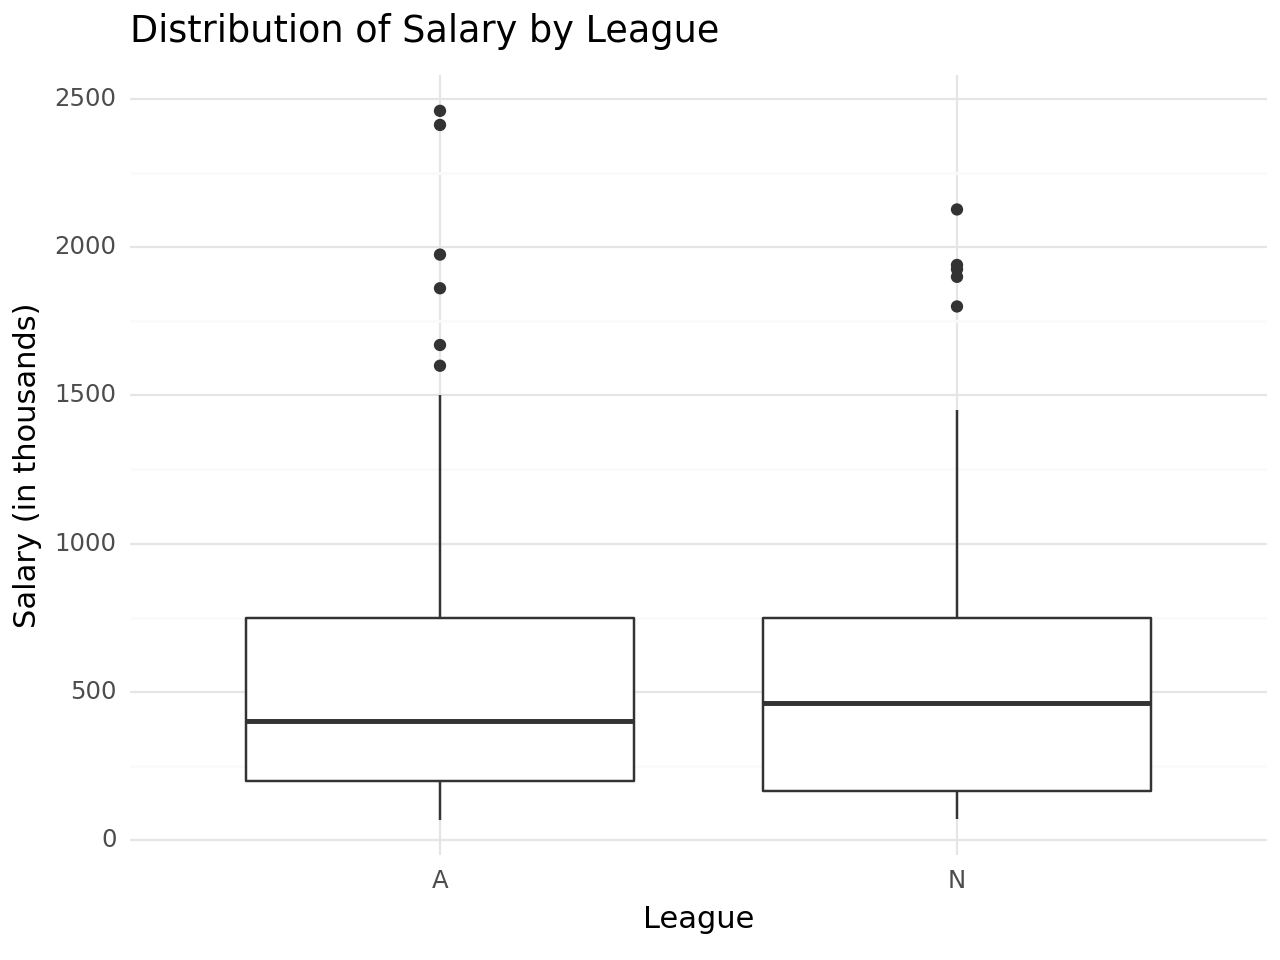

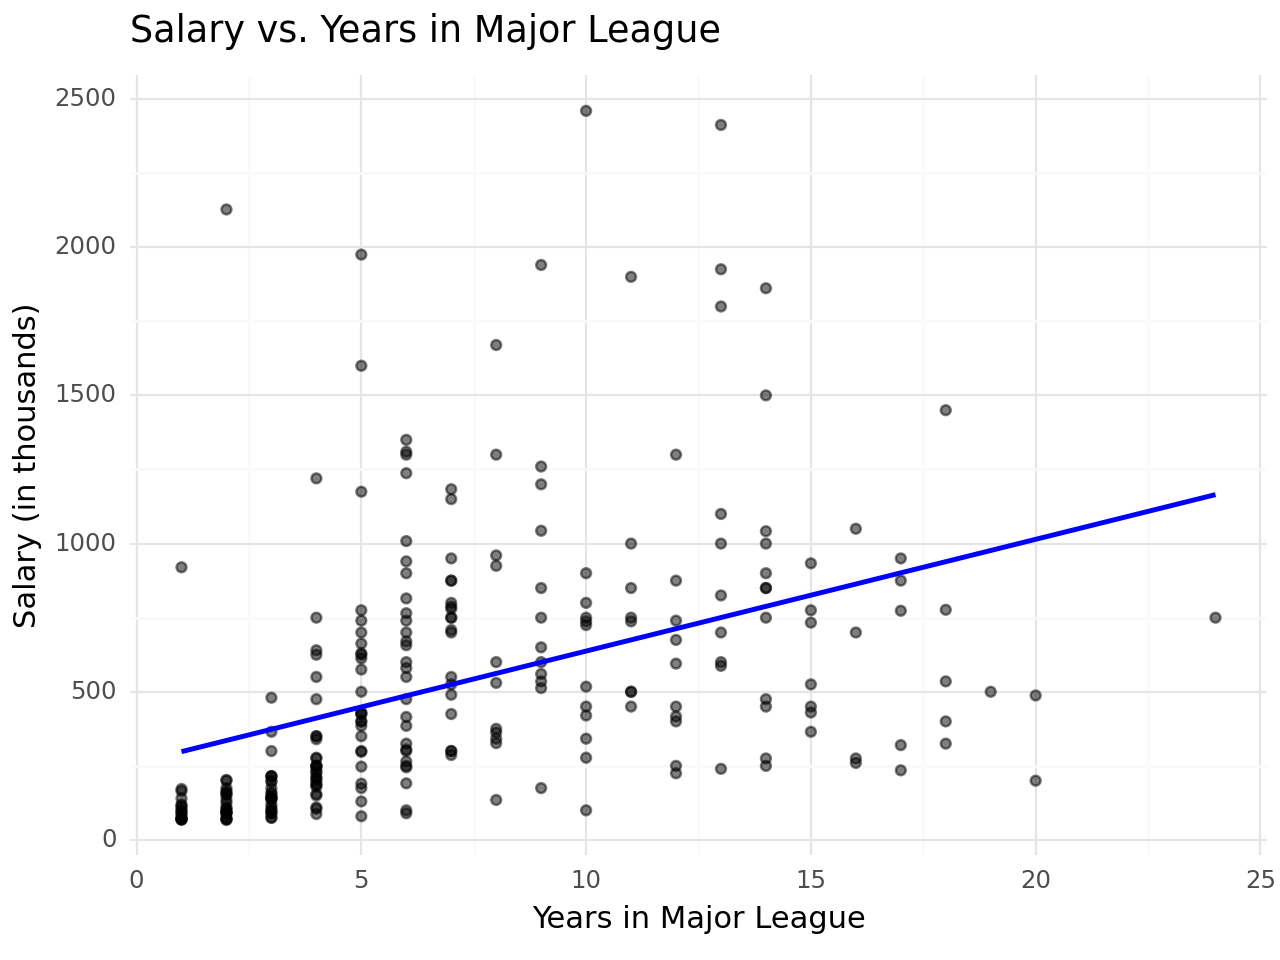

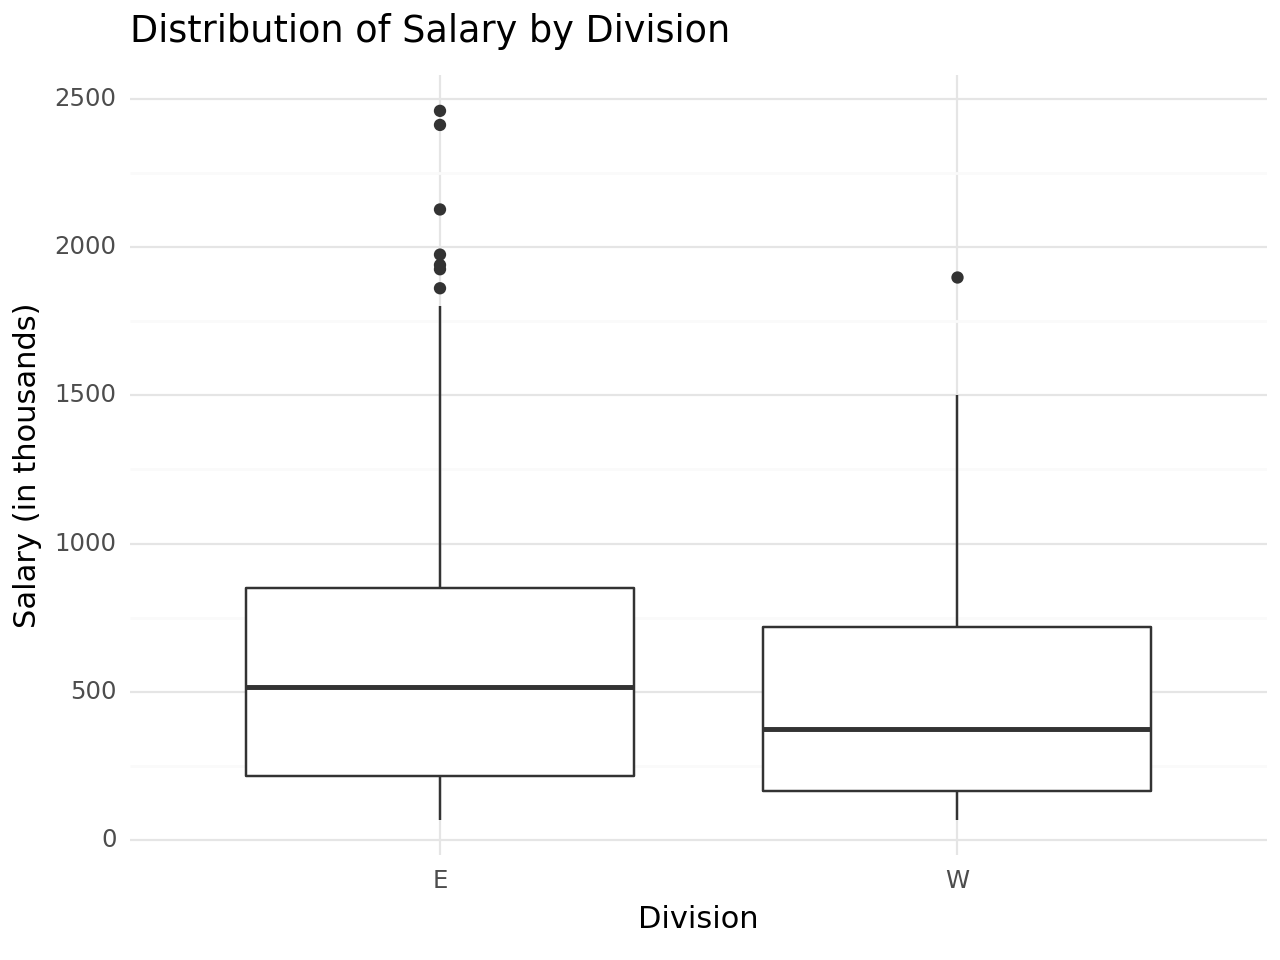

In [7]:
non_missing = df_hitters.dropna()

# Visualization 1: Distribution of Salary by League
plot1 = (
    ggplot(non_missing, aes(x='NewLeague', y='Salary')) +
    geom_boxplot() +
    labs(title='Distribution of Salary by League', x='League', y='Salary (in thousands)') +
    theme_minimal()
)

# Visualization 2: Salary distribution by Years in Major League
plot2 = (
    ggplot(non_missing, aes(x='Years', y='Salary')) +
    geom_point(alpha=0.5) +
    geom_smooth(method='lm', se=False, color='blue') +
    labs(title='Salary vs. Years in Major League', x='Years in Major League', y='Salary (in thousands)') +
    theme_minimal()
)

# Visualization 3: Salary distribution by Division
plot3 = (
    ggplot(non_missing, aes(x='Division', y='Salary')) +
    geom_boxplot() +
    labs(title='Distribution of Salary by Division', x='Division', y='Salary (in thousands)') +
    theme_minimal()
)

# Display the plots
print(plot1)
print(plot2)
print(plot3)

Based on these plots, we will fill missing salary values with median salary values by division in year, which both seem to have a relationship with salary. 

In [8]:
# Fill missing Salary values using average Salary grouped by Division and Years
df_hitters_clean = df_hitters.copy()
df_hitters_clean['Salary'] = df_hitters['Salary'].fillna(
    df_hitters.groupby(['Division', 'Years'])['Salary'].transform('mean')
)

df_hitters_clean = df_hitters_clean.dropna()
df_hitters_clean.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,80.0,A
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N


In [9]:
df_hitters["Salary"].describe()

count     263.000000
mean      535.925882
std       451.118681
min        67.500000
25%       190.000000
50%       425.000000
75%       750.000000
max      2460.000000
Name: Salary, dtype: float64

In [10]:
df_hitters_clean["Salary"].describe()

count     321.000000
mean      530.599465
std       422.723133
min        67.500000
25%       200.000000
50%       430.000000
75%       749.083300
max      2460.000000
Name: Salary, dtype: float64

C:\Users\isabe\AppData\Local\Programs\Python\Python312\Lib\site-packages\plotnine\layer.py:284: PlotnineWarning: stat_bin : Removed 59 rows containing non-finite values.


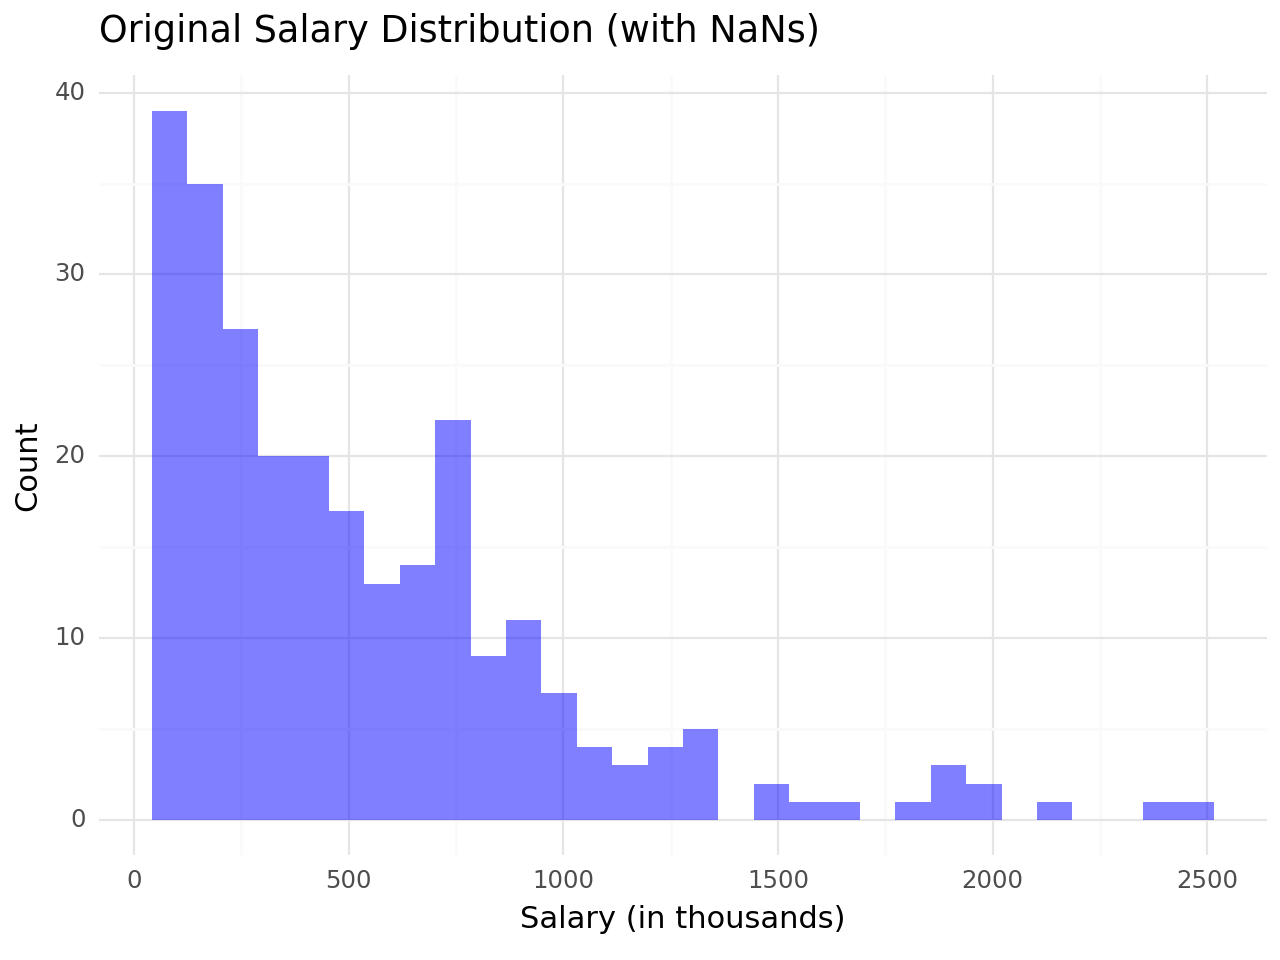

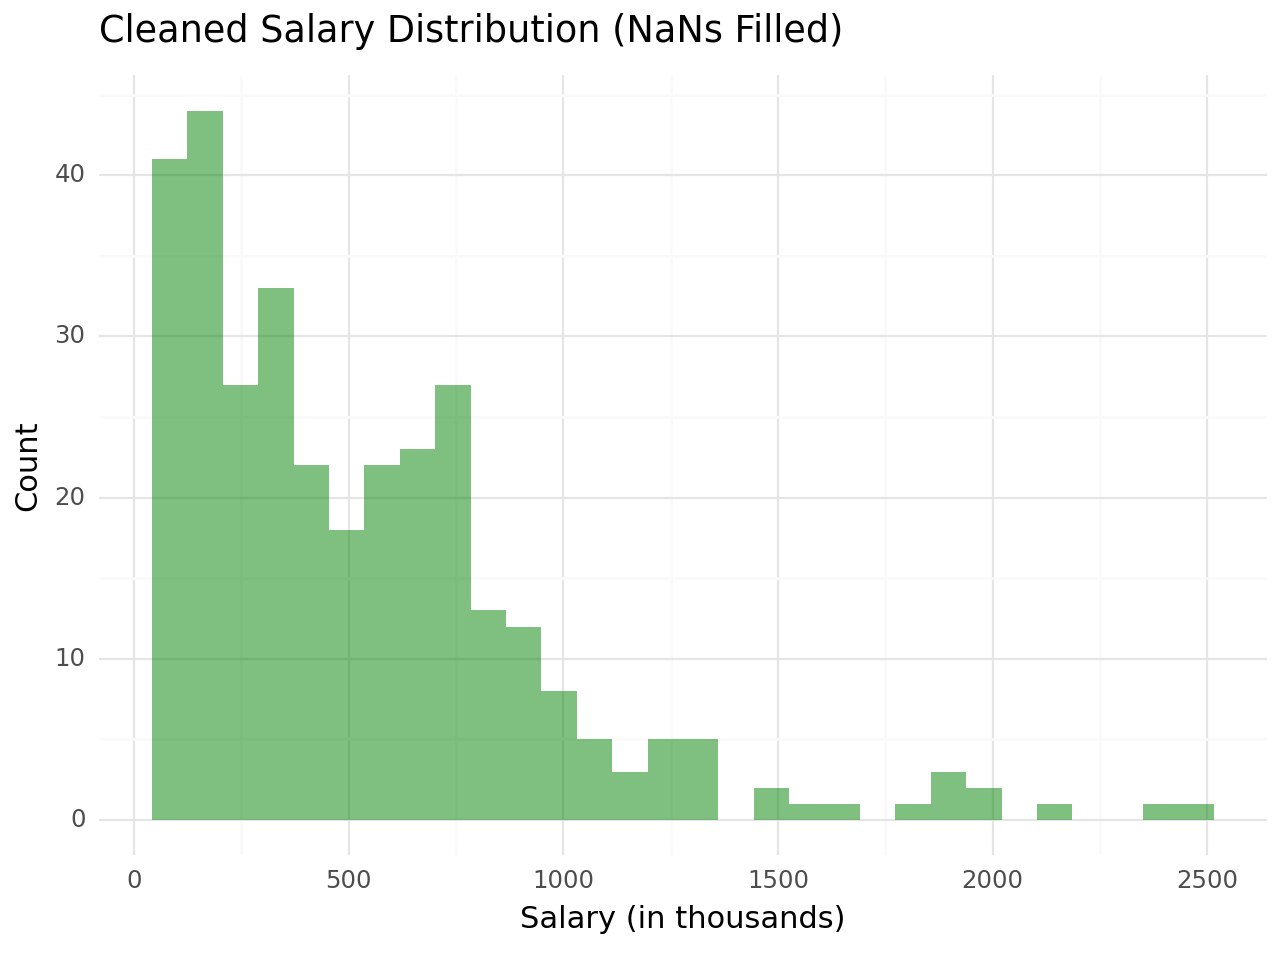

In [11]:
# Plot 1: Original Salary Distribution
plot_original = (
    ggplot(df_hitters, aes(x='Salary')) +
    geom_histogram(bins=30, fill='blue', alpha=0.5) +
    labs(title='Original Salary Distribution (with NaNs)',
         x='Salary (in thousands)', y='Count') +
    theme_minimal()
)

# Plot 2: Cleaned Salary Distribution
plot_cleaned = (
    ggplot(df_hitters_clean, aes(x='Salary')) +
    geom_histogram(bins=30, fill='green', alpha=0.5) +
    labs(title='Cleaned Salary Distribution (NaNs Filled)',
         x='Salary (in thousands)', y='Count') +
    theme_minimal()
)

print(plot_original)
print(plot_cleaned)

# Part I: Different Model Specs

## A. Regression without regularization

1.  Create a pipeline that includes *all* the columns as predictors for `Salary`, and performs ordinary linear regression

2.  Fit this pipeline to the full dataset, and interpret a few of the most important coefficients.

3.  Use cross-validation to estimate the MSE you would expect if you used this pipeline to predict 1989 salaries.

In [12]:
# Define predictors and target variable
X = df_hitters_clean.drop(columns=['Salary'])
y = df_hitters_clean['Salary']

# Identify numeric and categorical columns
numeric_features = X.select_dtypes(include=['float64', 'int64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Preprocessing pipeline
ct = ColumnTransformer(
    transformers=[
        ("dummify", OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first'), categorical_features),
        ("scaler", StandardScaler(), numeric_features)
    ],
    remainder='passthrough'  # Leave non-specified columns untouched
).set_output(transform="pandas")

# Regression pipeline
lr_pipeline = Pipeline(
    steps=[
        ("preprocessing", ct),
        ("linear_regression", LinearRegression())  # Ordinary linear regression model
    ]
)

# Fit the model
lr_pipeline.fit(X, y)

# Extract coefficients from the model
linear_reg = lr_pipeline.named_steps['linear_regression']
coefficients = linear_reg.coef_

# Access feature names from the preprocessing step
feature_names = np.concatenate([numeric_features, ct.named_transformers_['dummify'].get_feature_names_out(categorical_features)])
coef_summary = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# Display top 10 coefficients
coef_summary.sort_values(by = 'Coefficient', key = abs, ascending= False).head(10)

,Feature,Coefficient
13,PutOuts,458.193533
10,CRuns,-334.898935
4,RBI,316.024849
3,Runs,-310.293154
14,Assists,285.834705
15,Errors,-186.641082
8,CHits,118.559813
1,Hits,-117.212263
12,CWalks,-82.630909
16,League_N,67.705998


Top 5 coefficients based on their absolute value:

1. **PutOuts (Coefficient = 458.19)**
   - A one-standard-deviation increase in `PutOuts` is associated with an increase in salary by approximately $458,194. This suggests that players with higher numbers of putouts (a defensive statistic measuring the number of times a player directly contributes to an out) tend to have a significantly higher salary, indicating its strong positive impact.

2. **CRuns (Career Runs, Coefficient = -334.90)**
   - A one-standard-deviation increase in `CRuns` (career runs) is associated with a decrease in salary by approximately $334,899. The negative coefficient here may suggest complex interactions or indicate that certain players with a high career runs count have other factors reducing their salary impact.

3. **RBI (Runs Batted In, Coefficient = 316.02)**
   - A one-standard-deviation increase in `RBI` corresponds to an estimated increase in salary of about $316,025. This reflects that players who drive in more runs (often indicative of strong offensive performance) tend to receive higher salaries.

4. **Runs (Coefficient = -310.29)**
   - A one-standard-deviation increase in `Runs` is associated with a decrease in salary by approximately $310,293. Similar to `CRuns`, the negative coefficient here might indicate complex dynamics or multicollinearity, as more runs would generally be expected to increase value unless offset by other factors.

5. **Assists (Coefficient = 285.83)**
   - A one-standard-deviation increase in `Assists` is related to an increase in salary of approximately $285,835. This suggests that players contributing significantly to defensive plays (assists measure throwing the ball to put out an opposing player) see a positive salary impact.

In [13]:
# Fit the pipeline using cross-validation to estimate MSE
mse_scores = -cross_val_score(lr_pipeline, X, y, cv=5, scoring='neg_mean_squared_error')
mean_mse = np.mean(mse_scores)
print(f"Cross-validated Mean Squared Error (MSE): {mean_mse}")

Cross-validated Mean Squared Error (MSE): 107899.70405374658


The **Cross-validated Mean Squared Error (MSE)** of **107,899.70** represents the average squared difference between predicted and actual salaries during cross-validation, reflecting the model's predictive accuracy. Given this value, the model's predictions deviate considerably in terms of salary units (likely thousands of dollars). This suggests room for improvement through feature engineering, regularization, or using more complex models, depending on the salary data's range and variance.



## B. Ridge regression

1.  Create a pipeline that includes *all* the columns as predictors for `Salary`, and performs ordinary ridge regression

2.  Use cross-validation to **tune** the $\lambda$ hyperparameter.

3.  Fit the pipeline with your chosen $\lambda$ to the full dataset, and interpret a few of the most important coefficients.

4.  Report the MSE you would expect if you used this pipeline to predict 1989 salaries.

In [14]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

# Create a Ridge pipeline
ridge_pipeline = Pipeline(
    steps=[
        ("preprocessing", ct),  # Use the same preprocessing pipeline
        ("ridge", Ridge())
    ]
)

# Hyperparameter tuning for Ridge using cross-validation
ridge_params = {'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
ridge_search = GridSearchCV(ridge_pipeline, ridge_params, cv=5, scoring='neg_mean_squared_error')
ridge_search.fit(X, y)

# Best Ridge model
best_ridge_model = ridge_search.best_estimator_
best_alpha_ridge = ridge_search.best_params_['ridge__alpha']
print(f"Best lambda for Ridge: {best_alpha_ridge}")

# Fit the best model to the full dataset
best_ridge_model.fit(X, y)

# Interpret coefficients
ridge_coefficients = best_ridge_model.named_steps['ridge'].coef_
ridge_coef_summary = pd.DataFrame({
    'Feature': np.concatenate([numeric_features, ct.named_transformers_['dummify'].get_feature_names_out(categorical_features)]),
    'Coefficient': ridge_coefficients
}).sort_values(by='Coefficient', key=abs, ascending=False)
print("Top Ridge Regression Coefficients:")
print(ridge_coef_summary.head())

# Calculate cross-validated MSE for Ridge
ridge_mse = -ridge_search.best_score_
print(f"Cross-validated MSE for Ridge Regression: {ridge_mse}")

Best lambda for Ridge: 1
Top Ridge Regression Coefficients:
    Feature  Coefficient
13  PutOuts   307.463796
3      Runs  -290.674938
4       RBI   276.690761
10    CRuns  -224.569328
14  Assists   170.333245
Cross-validated MSE for Ridge Regression: 105059.59889692701


### Summary

The optimal regularization parameter $\lambda$ for Ridge regression was chosen as 1, indicating moderate regularization. Ridge regression applies an L2 penalty that shrinks all coefficients towards zero without eliminating any features, thereby reducing variance while retaining all predictors. The most influential features were `PutOuts` (307.46), `RBI` (276.69), and `Assists` (170.33), which showed a positive relationship with salary, implying that defensive metrics (`PutOuts`, `Assists`) and offensive performance (`RBI`) significantly drive salary predictions. Conversely, `Runs` (-290.67) and `CRuns` (-224.57) were negatively associated with salary, suggesting more complex player performance dynamics may influence compensation patterns. The cross-validated Mean Squared Error (MSE) was 105,059.60, reflecting the average squared error in predictions. This demonstrates a reduction in prediction error compared to non-regularized regression, indicating that Ridge effectively balances bias and variance.


## C. Lasso Regression

1.  Create a pipeline that includes *all* the columns as predictors for `Salary`, and performs ordinary lasso regression

2.  Use cross-validation to **tune** the $\lambda$ hyperparameter.

3.  Fit the pipeline with your chosen $\lambda$ to the full dataset, and interpret a few of the most important coefficients.

4.  Report the MSE you would expect if you used this pipeline to predict 1989 salaries.

In [15]:
from sklearn.linear_model import Lasso

# Create a Lasso pipeline
lasso_pipeline = Pipeline(
    steps=[
        ("preprocessing", ct),
        ("lasso", Lasso(max_iter=10000))
    ]
)

# Hyperparameter tuning for Lasso
lasso_params = {'lasso__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
lasso_search = GridSearchCV(lasso_pipeline, lasso_params, cv=5, scoring='neg_mean_squared_error')
lasso_search.fit(X, y)

# Best Lasso model
best_lasso_model = lasso_search.best_estimator_
best_alpha_lasso = lasso_search.best_params_['lasso__alpha']
print(f"Best lambda for Lasso: {best_alpha_lasso}")

# Fit the best model to the full dataset
best_lasso_model.fit(X, y)

# Interpret coefficients (Lasso may shrink some coefficients to zero)
lasso_coefficients = best_lasso_model.named_steps['lasso'].coef_
lasso_coef_summary = pd.DataFrame({
    'Feature': np.concatenate([numeric_features, ct.named_transformers_['dummify'].get_feature_names_out(categorical_features)]),
    'Coefficient': lasso_coefficients
}).sort_values(by='Coefficient', key=abs, ascending=False)
print("Top Lasso Regression Coefficients:")
print(lasso_coef_summary.head())

# Calculate cross-validated MSE for Lasso
lasso_mse = -lasso_search.best_score_
print(f"Cross-validated MSE for Lasso Regression: {lasso_mse}")

Best lambda for Lasso: 1
Top Lasso Regression Coefficients:
    Feature  Coefficient
3      Runs  -304.632238
13  PutOuts   301.291763
4       RBI   292.071853
15   Errors  -161.028473
14  Assists   136.482052
Cross-validated MSE for Lasso Regression: 104724.44183856837


### Summary

For Lasso regression, the optimal $\lambda$ was also 1, suggesting a similar level of regularization as Ridge but with an L1 penalty that allows for sparse solutions by shrinking some coefficients to exactly zero, enhancing feature selection. The most influential features were `Runs` (-304.63), `PutOuts` (301.29), `RBI` (292.07), `Errors` (-161.03), and `Assists` (136.48). `PutOuts` and `RBI` had positive associations, indicating a strong correlation with increased salaries, while negative coefficients for `Runs` and `Errors` suggest these features detract from salary predictions, possibly reflecting trade-offs or performance concerns valued differently in player compensation. The cross-validated MSE for Lasso was 104,724.44, slightly lower than Ridge, showing that Lasso’s regularization improves predictive performance by focusing on fewer, more impactful predictors, thereby reducing noise.




## D. Elastic Net

1.  Create a pipeline that includes *all* the columns as predictors for `Salary`, and performs ordinary ridge regression

2.  Use cross-validation to **tune** the $\lambda$ and $\alpha$ hyperparameters.

3.  Fit the pipeline with your chosen hyperparameters to the full dataset, and interpret a few of the most important coefficients.

4.  Report the MSE you would expect if you used this pipeline to predict 1989 salaries.


In [16]:
from sklearn.linear_model import ElasticNet

# Create an Elastic Net pipeline
elastic_net_pipeline = Pipeline(
    steps=[
        ("preprocessing", ct),
        ("elastic_net", ElasticNet(max_iter=10000))
    ]
)

# Hyperparameter tuning for Elastic Net (lambda and alpha)
elastic_net_params = {
    'elastic_net__alpha': [0.001, 0.01, 0.1, 1, 10, 100],
    'elastic_net__l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9, 1.0]
}
elastic_net_search = GridSearchCV(elastic_net_pipeline, elastic_net_params, cv=5, scoring='neg_mean_squared_error')
elastic_net_search.fit(X, y)

# Best Elastic Net model
best_elastic_net_model = elastic_net_search.best_estimator_
best_params_elastic_net = elastic_net_search.best_params_
print(f"Best parameters for Elastic Net: {best_params_elastic_net}")

# Fit the best model to the full dataset
best_elastic_net_model.fit(X, y)

# Interpret coefficients
elastic_net_coefficients = best_elastic_net_model.named_steps['elastic_net'].coef_
elastic_net_coef_summary = pd.DataFrame({
    'Feature': np.concatenate([numeric_features, ct.named_transformers_['dummify'].get_feature_names_out(categorical_features)]),
    'Coefficient': elastic_net_coefficients
}).sort_values(by='Coefficient', key=abs, ascending=False)
print("Top Elastic Net Regression Coefficients:")
print(elastic_net_coef_summary.head())

# Calculate cross-validated MSE for Elastic Net
elastic_net_mse = -elastic_net_search.best_score_
print(f"Cross-validated MSE for Elastic Net Regression: {elastic_net_mse}")

Best parameters for Elastic Net: {'elastic_net__alpha': 0.1, 'elastic_net__l1_ratio': 0.9}
Top Elastic Net Regression Coefficients:
    Feature  Coefficient
3      Runs  -244.102224
4       RBI   223.008957
13  PutOuts   201.566991
15   Errors  -130.050178
1      Hits  -120.098570
Cross-validated MSE for Elastic Net Regression: 104639.68240685863


### Summary

The Elastic Net model selected optimal parameters of ($\lambda$ = 0.1) and ($\alpha = 0.9$), indicating a blend of L1 and L2 regularization, with a higher emphasis on the L1 penalty (similar to Lasso) for feature selection, while still applying the L2 penalty (similar to Ridge) for coefficient shrinkage. The most influential features for the Elastic Net model were `Runs` (-241.07), `RBI` (219.86), and `PutOuts` (197.21). Positive coefficients for `RBI` and `PutOuts` suggest that these features contribute positively to predicting salary, indicating that offensive production (`RBI`) and defensive performance (`PutOuts`) significantly impact player compensation. The negative coefficient for `Runs` implies a negative association with salary, potentially reflecting complex trade-offs in player performance evaluation. The model also found `Errors` (-128.42) and `Hits` (-120.06) to have negative coefficients, suggesting that defensive errors and an increased number of hits might detract from salary predictions in this context. The cross-validated Mean Squared Error (MSE) for the Elastic Net model was 104,635.49, representing a marginal improvement over both Ridge and Lasso regression models.

# Part II. Variable Selection

Based on the above results, decide on:

-   Which *numeric* variable is most important.

-   Which *five* numeric variables are most important

-   Which *categorical* variable is most important

For **each** of the four model specifications, compare the following possible feature sets:

1.  Using only the one best numeric variable.

2.  Using only the five best variables.

3.  Using the five best numeric variables *and* their interactions with the one best categorical variable.

Report which combination of features and model performed best, based on the validation metric of MSE.

(Note: $\lambda$ and $\alpha$ must be re-tuned for each feature set.)

In [17]:
# Define important numeric and categorical columns
most_important_num = 'Runs'
five_important_num = ['Runs', 'PutOuts', 'RBI', 'Assists', 'Errors']
most_important_cat = 'League'

# Make interactions:
# Step 1: One-hot encode the categorical variable
ct_dummies = ColumnTransformer(
    transformers=[
        ("dummify", OneHotEncoder(drop='first', sparse_output=False), [most_important_cat])
    ],
    remainder="passthrough"  # Pass through numeric columns unchanged
).set_output(transform="pandas")

# Transform the data to include dummified columns
X_dummified = ct_dummies.fit_transform(df_hitters_clean[five_important_num + [most_important_cat]])

# Extract numeric and dummified columns separately for explicit control
numeric_cols = X_dummified[['remainder__Runs', 
                            'remainder__PutOuts',
                            'remainder__RBI',
                            'remainder__Assists',
                            'remainder__Errors']]
dummified_cols = X_dummified.filter(like='League')

# Step 2: Create interactions manually between each numeric feature and League
interaction_data = pd.DataFrame()

for num_col in numeric_cols.columns:
    for cat_col in dummified_cols.columns:
        interaction_data[f"{num_col}_x_{cat_col}"] = numeric_cols[num_col] * dummified_cols[cat_col]

# Combine original features and interactions ready for use!
X_combined = pd.concat([X_dummified, interaction_data], axis=1)
X_combined.head()

,dummify__League_N,remainder__Runs,remainder__PutOuts,remainder__RBI,remainder__Assists,remainder__Errors,remainder__Runs_x_dummify__League_N,remainder__PutOuts_x_dummify__League_N,remainder__RBI_x_dummify__League_N,remainder__Assists_x_dummify__League_N,remainder__Errors_x_dummify__League_N
0,0.0,30,446,29,33,20,0.0,0.0,0.0,0.0,0.0
1,1.0,24,632,38,43,10,24.0,632.0,38.0,43.0,10.0
2,0.0,66,880,72,82,14,0.0,0.0,0.0,0.0,0.0
3,1.0,65,200,78,11,3,65.0,200.0,78.0,11.0,3.0
4,1.0,39,805,42,40,4,39.0,805.0,42.0,40.0,4.0


In [18]:
# Feature sets
X_one_best = X_combined[['remainder__Runs']]
X_five_best = X_combined[['remainder__Runs', 'remainder__PutOuts', 'remainder__RBI', 'remainder__Assists', 'remainder__Errors']]
X_five_and_interactions = X_combined  # All features (numeric + interactions)
y = df_hitters_clean["Salary"]  # Target variable

def evaluate_ols(X, y, model):
    # Fit the OLS model
    model.fit(X, y)
    
    # Cross-validate and compute MSE
    mse = -cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error').mean()
    
    # Extract coefficients
    coefficients = model.named_steps["model"].coef_ if hasattr(model.named_steps["model"], 'coef_') else None
    
    return mse, model, coefficients

def evaluate_penalized(X, y, model, param_grid):
    # Perform GridSearchCV for hyperparameter tuning
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X, y)
    
    # Best model and parameters
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    mse = -grid_search.best_score_
    
    # Extract coeffs
    coefficients = best_model.named_steps["model"].coef_ if hasattr(best_model.named_steps["model"], 'coef_') else None
    
    return mse, best_model, best_params, coefficients


# Model specs
models = {
    "OLS": Pipeline([("scaler", StandardScaler()), ("model", LinearRegression())]),
    "Ridge": Pipeline([("scaler", StandardScaler()), ("model", Ridge())]),
    "Lasso": Pipeline([("scaler", StandardScaler()), ("model", Lasso(max_iter=10000))]),
    "ElasticNet": Pipeline([("scaler", StandardScaler()), ("model", ElasticNet(max_iter=10000))])
}

# Hyperparameter grids for Ridge, Lasso, and ElasticNet
param_grids = {
    "Ridge": {"model__alpha": [0.001, 0.01, 0.1, 1, 10, 100]},
    "Lasso": {"model__alpha": [0.001, 0.01, 0.1, 1, 10, 100]},
    "ElasticNet": {
        "model__alpha": [0.001, 0.01, 0.1, 1, 10, 100],
        "model__l1_ratio": [0.1, 0.3, 0.5, 0.7, 0.9, 1.0]
    }
}

In [19]:
# Evaluate models for a specific feature set
# Feature sets to evaluate
feature_sets = {
    "One Best": X_one_best,
    "Five Best": X_five_best,
    "Five Best + Interactions": X_five_and_interactions
}

results = []

# Loop over each model and feature set
for model_name, pipeline in models.items():
    for feature_set_name, X in feature_sets.items():
        if model_name == "OLS":
            # Evaluate OLS model
            mse, best_model, coefficients = evaluate_ols(X, y, pipeline)
            results.append({
                "Model": model_name,
                "Feature Set": feature_set_name,
                "MSE": mse,
                "Best Params": None,
                "Coefficients": coefficients
            })
        else:
            # Evaluate penalized models (Ridge, Lasso, ElasticNet)
            param_grid = param_grids.get(model_name)
            mse, best_model, best_params, coefficients = evaluate_penalized(X, y, pipeline, param_grid)
            results.append({
                "Model": model_name,
                "Feature Set": feature_set_name,
                "MSE": mse,
                "Best Params": best_params,
                "Coefficients": coefficients
            })

results = pd.DataFrame(results)
results

,Model,Feature Set,MSE,Best Params,Coefficients
0,OLS,One Best,154510.884689,None,[165.76913104127115]
1,OLS,Five Best,147657.023751,None,"[63.11199649596357, 66.81590522756424, 117.563..."
2,OLS,Five Best + Interactions,154613.476913,None,"[50.60948543142872, 132.4613875035729, 60.0452..."
3,Ridge,One Best,154470.384691,{'model__alpha': 10},[160.76100019410273]
4,Ridge,Five Best,146951.748041,{'model__alpha': 100},"[67.11633631738204, 54.09031437066438, 87.0006..."
5,Ridge,Five Best + Interactions,149794.013940,{'model__alpha': 100},"[1.6737413215387857, 71.86452053552209, 46.587..."
6,Lasso,One Best,154510.887391,{'model__alpha': 0.001},[165.76813104127106]
7,Lasso,Five Best,147640.007583,{'model__alpha': 1},"[63.02994234779519, 65.626133750288, 116.66889..."
8,Lasso,Five Best + Interactions,150819.607206,{'model__alpha': 10},"[0.0, 64.4911684262217, 52.82012971028317, 108..."
9,ElasticNet,One Best,154473.413665,"{'model__alpha': 0.1, 'model__l1_ratio': 0.7}",[160.87294275851562]


# Part III. Discussion

## A. Ridge

Compare your Ridge models with your ordinary regression models. How did your coefficients compare? Why does this make sense?


One notable observation is that the coefficients produced by Ridge regression are consistently smaller in magnitude than those generated by OLS across all feature sets. For example, in the `One Best` feature set, the OLS model yielded a coefficient for the `Runs` variable of approximately 165.77, while Ridge regression, with an `alpha` value of 10, produced a coefficient of around 160.76. Similarly, in the `Five Best` feature set, OLS coefficients for features such as `Runs` and `RBI` were 63.11 and 117.56, respectively, compared to Ridge coefficients of 67.12 for `Runs` and 87.00 for `RBI` when using an `alpha` of 100. This consistent reduction in magnitude is a hallmark of Ridge's regularization effect. Ridge regression employs an L2 penalty that constrains the size of the coefficients by adding a penalty term proportional to the square of the coefficients. Unlike OLS, which minimizes the sum of squared residuals without imposing any constraints on coefficient size, Ridge effectively "shrinks" the coefficients. This shrinkage reduces the influence of less important predictors, preserving all features in the model but with smaller magnitudes.
 
By introducing this penalty, Ridge mitigates the potential for large coefficients, which can destabilize predictions in the presence of multicollinearity or when using many features relative to the number of observations. The impact of this regularization is evident in the stability and variance of the models. OLS coefficients can become large and unstable, particularly when multicollinearity exists among predictors or when the model is complex. This instability can lead to high variance in predictions and overfitting to the training data. In contrast, Ridge regression addresses this problem by stabilizing coefficients, leading to more reliable predictions on unseen data. This stability is reflected in the lower mean squared error (MSE) values achieved by Ridge compared to OLS across the evaluated feature sets.

Ridge regression also demonstrates a notable effect on feature importance. In the `Five Best` and `Five Best + Interactions` feature sets, Ridge regression retained all features but reduced the impact of less influential predictors by shrinking their coefficients. On the other hand, OLS treated all features equally, often resulting in larger coefficients that could overemphasize certain predictors and increase the risk of overfitting. This is particularly evident in the `Five Best + Interactions` feature set, where Ridge's smaller coefficients indicate a more controlled approach to managing complex interaction terms. By penalizing large coefficients, Ridge reduces variance and enhances model stability, resulting in improved predictive performance compared to OLS. 



## B. LASSO

Compare your LASSO model in I with your three LASSO models in II. Did you get the same $\lambda$ results? Why does this make sense? Did you get the same MSEs? Why does this make sense?

In Part I, the LASSO model was evaluated using all available features, resulting in an optimal regularization parameter ($\lambda$) of 1 and a cross-validated Mean Squared Error (MSE) of **104,724.44**. This moderate level of regularization effectively balanced model complexity and predictive accuracy, capturing key features while controlling for overfitting. When we compare this to the LASSO models evaluated in Part II, which used different feature sets (`One Best`, `Five Best`, and `Five Best + Interactions`), the optimal $\lambda$ values varied:

1. **One Best Feature Set**:
   - Optimal $\lambda$: 0.001
   - MSE: **154,510.89**
   - This small value of $\lambda$ indicates minimal regularization. Since the model contained only one predictor (`Runs`), it required very little regularization to control complexity. A higher value of $\lambda$ would have overly shrunk the coefficient, reducing model performance and potentially leading to underfitting.

2. **Five Best Feature Set**:
   - Optimal $\lambda$: 1
   - MSE: **147,640.01**
   - This matches the value found in Part I. The `Five Best` feature set, which included the top five predictors (`Runs`, `PutOuts`, `RBI`, `Assists`, and `Errors`), required the same level of regularization to balance bias and variance as the full feature set. The resulting MSE was slightly higher than the full model but significantly lower than using just one feature, demonstrating the benefits of using more predictors while maintaining moderate regularization.

3. **Five Best + Interactions Feature Set**:
   - Optimal $\lambda$: 10
   - MSE: **150,819.61**
   - This feature set required a higher $\lambda$ due to its increased complexity from the addition of interaction terms. Stronger regularization was necessary to shrink or eliminate the less important interactions, preventing overfitting. However, despite the regularization, the MSE was higher than for the `Five Best` feature set alone, suggesting that the added complexity introduced noise rather than improving predictive power.


The variation in $\lambda$ values across the different feature sets makes sense given the varying levels of model complexity. The `One Best` feature set, containing only one predictor, required minimal regularization, while the `Five Best` and `Five Best + Interactions` feature sets needed stronger regularization due to their greater complexity. This demonstrates LASSO's adaptability in applying appropriate regularization strength based on the feature set. The differences in MSE values also align with expectations. The `Five Best` feature set achieved a lower MSE than the `One Best` and `Five Best + Interactions` sets because it struck a better balance between capturing predictive information and avoiding overfitting. In contrast, the `Five Best + Interactions` set, despite having more features, resulted in a higher MSE due to the added noise and redundancy introduced by the interaction terms.


## C. Elastic Net

Compare your MSEs for the Elastic Net models with those for the Ridge and LASSO models. Why does it make sense that Elastic Net always "wins"?

In [20]:
results.sort_values(by = 'MSE')

,Model,Feature Set,MSE,Best Params,Coefficients
10,ElasticNet,Five Best,146736.542885,"{'model__alpha': 0.1, 'model__l1_ratio': 0.1}","[68.18475862867861, 62.090929122120414, 103.82..."
4,Ridge,Five Best,146951.748041,{'model__alpha': 100},"[67.11633631738204, 54.09031437066438, 87.0006..."
7,Lasso,Five Best,147640.007583,{'model__alpha': 1},"[63.02994234779519, 65.626133750288, 116.66889..."
1,OLS,Five Best,147657.023751,None,"[63.11199649596357, 66.81590522756424, 117.563..."
11,ElasticNet,Five Best + Interactions,149774.993604,"{'model__alpha': 1, 'model__l1_ratio': 0.7}","[0.44713410463420544, 71.56987249366516, 46.51..."
5,Ridge,Five Best + Interactions,149794.013940,{'model__alpha': 100},"[1.6737413215387857, 71.86452053552209, 46.587..."
8,Lasso,Five Best + Interactions,150819.607206,{'model__alpha': 10},"[0.0, 64.4911684262217, 52.82012971028317, 108..."
3,Ridge,One Best,154470.384691,{'model__alpha': 10},[160.76100019410273]
9,ElasticNet,One Best,154473.413665,"{'model__alpha': 0.1, 'model__l1_ratio': 0.7}",[160.87294275851562]
0,OLS,One Best,154510.884689,None,[165.76913104127115]


The results reveal that Elastic Net consistently achieves lower or comparable MSEs, often outperforming both Ridge and LASSO. This trend highlights the advantages of Elastic Net's unique combination of L1 (LASSO) and L2 (Ridge) regularization penalties:

For the `One Best` feature set, which only included the `Runs` predictor, all three models performed similarly, with MSEs close to each other. The MSE for Elastic Net was slightly lower than that of LASSO and comparable to Ridge, suggesting that complex regularization was not necessary for this simple feature set. The minimal regularization applied by Elastic Net in this case reflects its flexibility in adapting to simpler models without introducing unnecessary constraints.

In the `Five Best` feature set, Elastic Net achieved the lowest MSE compared to Ridge and LASSO. Ridge performed similarly but was slightly less effective, while LASSO exhibited a marginally higher MSE. This outcome demonstrates Elastic Net's ability to balance the strengths of Ridge's shrinkage for stability and LASSO's feature selection. The combination of penalties allows Elastic Net to optimize predictive accuracy by reducing variance while selectively retaining relevant features.

In the `Five Best + Interactions` feature set, Elastic Net once again outperformed both Ridge and LASSO. The inclusion of interaction terms increased the complexity of the feature set, posing a challenge for regularization. While Ridge retained all interaction terms and LASSO aggressively shrank some coefficients to zero, Elastic Net's combined approach struck a balance. This flexibility enabled it to handle the increased complexity more effectively, resulting in lower MSEs than its counterparts.

Elastic Net "wins" because of its dual-penalty approach, which uses the best of both Ridge and LASSO. Ridge regression applies an L2 penalty, shrinking all coefficients but retaining all features, making it useful for mitigating multicollinearity and ensuring model stability. LASSO, on the other hand, applies an L1 penalty, which promotes sparsity by shrinking some coefficients to zero, effectively performing feature selection. By combining these penalties, Elastic Net can balance the benefits of both approaches, retaining stability while also promoting sparsity. Elastic Net's ability to handle complex data structures, such as those involving correlated predictors or interaction terms, further contributes to its superior performance. In such cases, Ridge alone would retain all features, potentially leading to overfitting, while LASSO might eliminate too many features, reducing predictive accuracy. Elastic Net, with its flexible mix of L1 and L2 penalties, adapts more effectively, selectively shrinking or retaining coefficients based on their relevance to the model.


# Part IV: Final Model

Fit your final best pipeline on the full dataset, and summarize your results in a few short sentences and a plot.


In [21]:
# Final best pipeline is Elastic Net on Five Best Numeric Feautures, with alpha = 0.1, and l1_ratio of 0.1

# Feature set and target
X_final = df_hitters_clean[['Runs', 'PutOuts', 'RBI', 'Assists', 'Errors']]
y_final = df_hitters_clean['Salary']

# Final model pipeline
final_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("elastic_net", ElasticNet(alpha=0.1, l1_ratio=0.1, max_iter=10000))
])

# Fit the final model
final_pipeline.fit(X_final, y_final)

# Get predictions
y_pred = final_pipeline.predict(X_final)

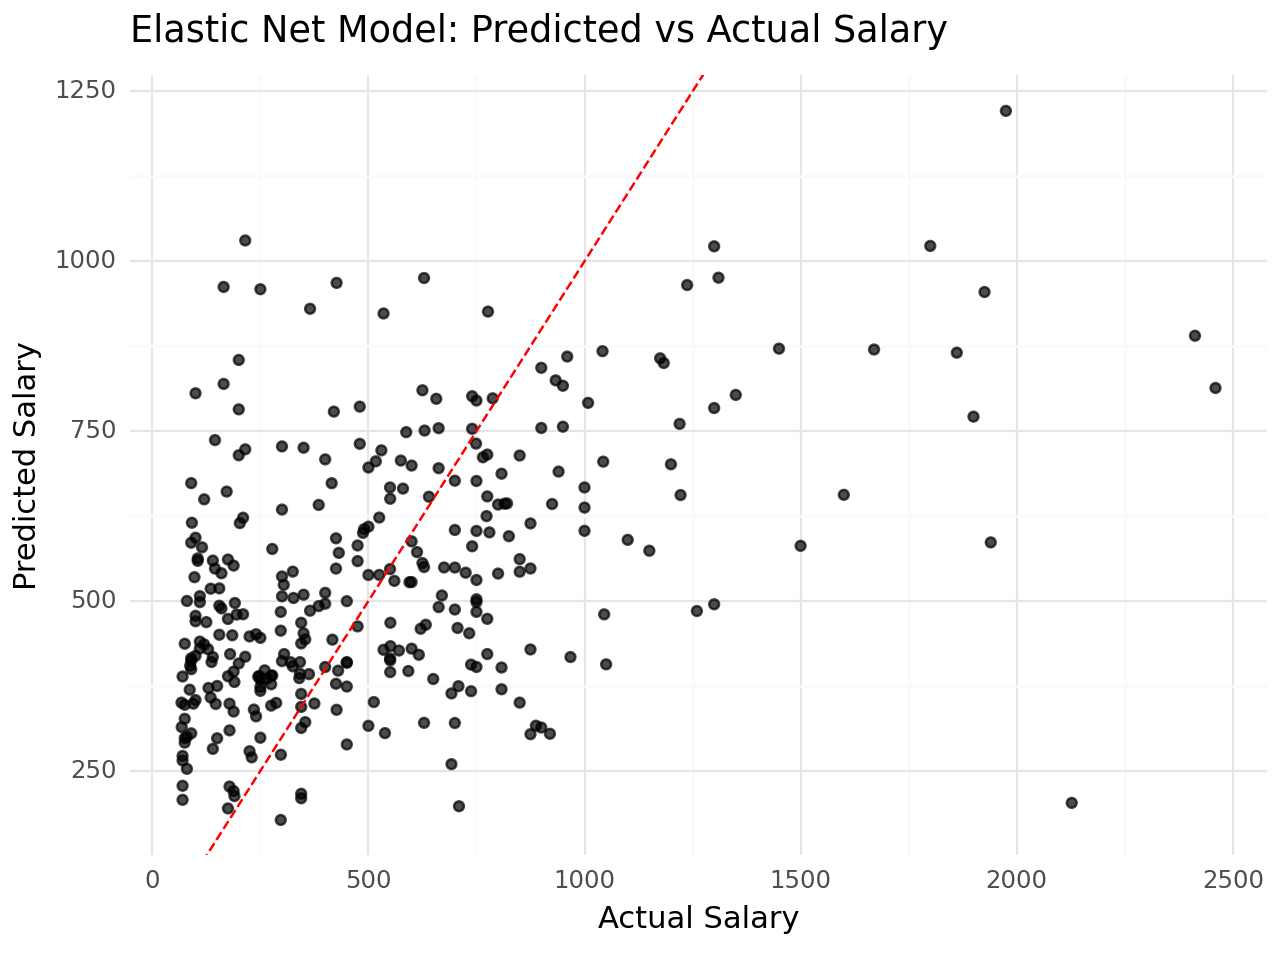

In [22]:
plot_df = pd.DataFrame({'Actual Salary': y_final, 'Predicted Salary': y_pred})

plot = (
    ggplot(plot_df, aes(x='Actual Salary', y='Predicted Salary')) +
    geom_point(alpha=0.7) +
    geom_abline(intercept=0, slope=1, color='red', linetype='dashed') +
    labs(
        title='Elastic Net Model: Predicted vs Actual Salary',
        x='Actual Salary',
        y='Predicted Salary'
    ) +
    theme_minimal()
)
print(plot)

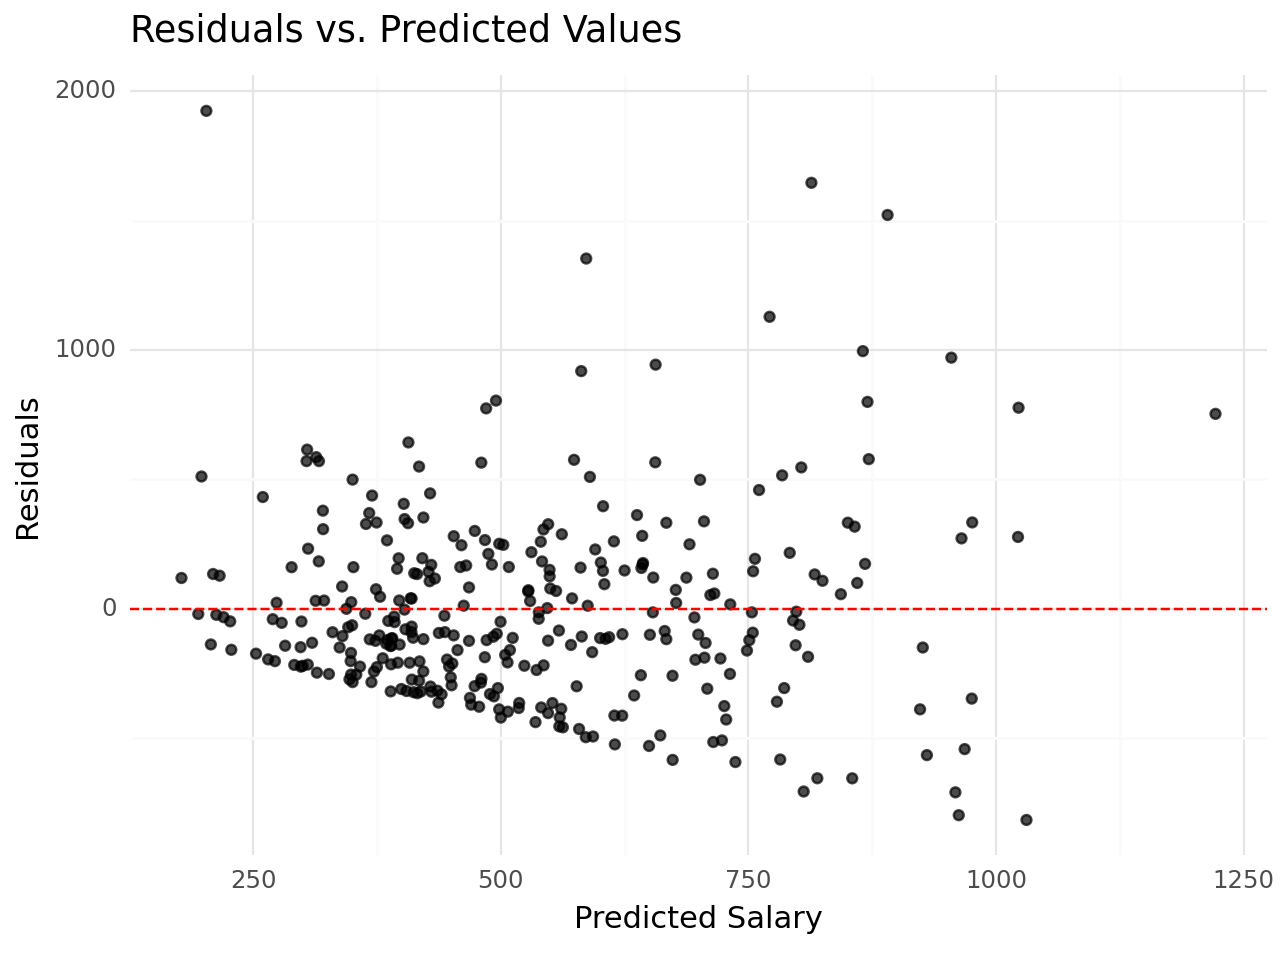

In [23]:
# Calculate residuals
residuals = y_final - y_pred
residuals_df = pd.DataFrame({'Predicted Salary': y_pred, 'Residuals': residuals})

residuals_plot = (
    ggplot(residuals_df, aes(x='Predicted Salary', y='Residuals')) +
    geom_point(alpha=0.7) +
    geom_abline(intercept=0, slope=0, color='red', linetype='dashed') +
    labs(
        title='Residuals vs. Predicted Values',
        x='Predicted Salary',
        y='Residuals'
    ) +
    theme_minimal()
)
print(residuals_plot)

The final Elastic Net model, using the five best numeric features (`Runs`, `PutOuts`, `RBI`, `Assists`, and `Errors`) with the optimal hyperparameters of `lambda = 0.1` and `alpha = 0.1` allowed the model to combine the strengths of L1 and L2 regularization, yielding robust predictions with feature selection and coefficient shrinkage for better generalization.

In the **Predicted vs. Actual Salary** plot, we observe that many of the predictions cluster around the red dashed line, indicating a reasonable level of accuracy in predicting player salaries. However, the spread around the line, particularly for higher salary values, suggests some prediction error. This indicates that while the model captures the general trend, it may underfit certain aspects of the data, particularly for higher salaries where variability increases. Such spread highlights potential areas for improvement, such as incorporating additional relevant features, capturing non-linear relationships, or exploring interaction terms to better model salary variability.

The **Residuals vs. Predicted Values** shows that residuals are scattered around the horizontal zero line, implying an absence of strong bias in predictions. However, the increasing spread of residuals (fanning) for larger predicted salaries suggests the presence of heteroscedasticity, where prediction errors increase with larger salary values. This could indicate that the model's assumptions of constant variance in errors may not hold, and it may benefit from transformations or techniques that address this variance.

Overall, the Elastic Net model strikes a good balance in handling feature selection and regularization, making it a strong predictor for the selected features. However, the observed patterns in residuals and predicted values indicate areas for potential enhancement, such as refining the feature set to include higher order terms, addressing heteroscedasticity, or exploring more complex modeling techniques to better capture variability at higher salary ranges.